# Setup

Import all packages necessary

In [ ]:
from os.path import basename, exists

def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve
    local, _ = urlretrieve(url, filename)
    print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from Cell2D import Cell2D, draw_array
from utils import set_palette, decorate, three_frame

# Model

## Global Variables

In [ ]:
# Cell States
EMPTY = 0
SUSCEPTIBLE = 1
INCUBATING = 2
SICK = 3
IMMUNE = 4

# Periods
INCUBATION_PERIOD = 2
SICK_PERIOD = 10
IMMUNITY_PERIOD = 5

# Probabilities
T_PROB = 0.3 #Transmission probability (0-1)
I_PROB = 0.5 #Interaction probability (0-1)

#Modes for get_visible_neighbors
EMPTY = 0
AGENTS = 1

## Agent Class

In [ ]:
class Agent:
  """Represents an agent in the simulation."""
  next_id = 0  # Class variable to keep track of the next available ID
  def __init__(self, x, y, health_state=SUSCEPTIBLE, max_vis=1):
    """Initialize an agent with a position and state."""
    self.x = x
    self.y = y
    self.health_state = health_state
    self.id = Agent.next_id
    # Make sure the next agent's ID is not the same (next number)
    Agent.next_id += 1
    self.incubation_timer = INCUBATION_PERIOD if health_state == INCUBATING else 0
    self.infection_timer = SICK_PERIOD if health_state == SICK else 0
    self.immunity_timer = IMMUNITY_PERIOD if health_state == IMMUNE else 0
    self.vision = np.random.randint(1, max_vis+1)

  def update_state(self):
    """Update the agent's state based on its current state."""
    if self.health_state == INCUBATING:
      self.incubation_timer -= 1
      if self.incubation_timer <= 0:
        self.health_state = SICK
        self.infection_timer = SICK_PERIOD
    elif self.health_state == SICK:
      self.infection_timer -= 1
      if self.infection_timer <= 0:
        self.health_state = IMMUNE
        self.immunity_timer = IMMUNITY_PERIOD
    elif self.health_state == IMMUNE:
      self.immunity_timer -= 1
      if self.immunity_timer <= 0:
        self.health_state = SUSCEPTIBLE

  def is_infectious(self):
    """Check if the agent is infectious."""
    return True if (self.health_state == INCUBATING or self.health_state == SICK) else False

  def infect(self):
    """Infect the agent if susceptible."""
    if self.health_state == SUSCEPTIBLE:
      self.health_state = INCUBATING
      self.incubation_timer = INCUBATION_PERIOD

  def is_susceptible(self):
    """Check if the agent is susceptible."""
    return True if self.health_state == SUSCEPTIBLE else False

## DAS Class

In [ ]:
class DAS(Cell2D):
  """Model of disease avoidance stigmatization."""
  def __init__(self, w, h, num_agents, num_infected, t_prob=T_PROB, i_prob=I_PROB, max_vis=1):
    Agent.next_id = 0
    self.w = w
    self.h = h
    self.t_prob = t_prob
    self.i_prob = i_prob

    # Initialize all cells as being EMPTY
    self.array = np.full((self.h, self.w), None)

    # Initialize agents with random positions and populate the grid
    self.agents = []
    free_cells = [(x, y) for x in range(self.w) for y in range(self.h)]
    np.random.shuffle(free_cells)
    for _ in range(num_agents):
      if not free_cells:
        break
      x, y = free_cells.pop()
      agent = Agent(x, y, max_vis=max_vis)
      self.agents.append(agent)
      self.array[y, x] = agent

    # Infect a subset of agents initially
    num_infected = min(num_infected, len(self.agents))
    infected_agents = np.random.choice(self.agents, num_infected, replace=False)
    for agent in infected_agents:
      agent.health_state = INCUBATING
      agent.incubation_timer = INCUBATION_PERIOD

    # Define colour map for visualization
    self.cmap = ListedColormap(['white', 'blue', 'yellow', 'red', 'green'])
    # Mapping:
    # EMPTY (0): white
    # SUSCEPTIBLE (1): blue
    # INCUBATING (2): orange
    # SICK (3): red
    # IMMUNE (4): green
    self.current_loneliness = np.zeros(num_agents)

  # Same principle as vision radius code from Week 7 Lab - Agent Based Modelling I
  def get_visible_neighbors(self, x, y, vision, mode):
    """Get all visible neighbors of a cell within a vision raidus.

    Uses 8-n logic when vision raidus is 1, otherwise uses 4-n logic.

    x, y: Coordinates of the cell.
    vision: Vision radius.

    returns: List of visible neighbors.
    """
    neighbors = []

    if mode == AGENTS:
      # 8-n logic
      # used to obtain all directly neighbouring agents
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          if dx == 0 and dy == 0:
            continue  # Skip the cell itself
          nx, ny = x + dx, y + dy
          if 0 <= nx < self.w and 0 <= ny < self.h:
            if self.array[ny, nx] is not None:
              neighbors.append((nx, ny))

    else:
      # 4-n logic
      # used to obtain all visible empty spaces
      for d in range(1, vision + 1):
        a = np.array([[-d, 0], [d, 0], [0,-d], [0, d]])
        for loc in a:
          dx, dy = loc
          nx, ny = x + dx, y + dy
          if 0 <= nx < self.w and 0 <= ny < self.h:
            if self.array[ny, nx] is None:
              neighbors.append((nx, ny))

    return neighbors

  def check_sick(self, neighbors):
    """Check if any of the neighbors are sick."""
    num_sick_neighbors = 0
    for neighbor in neighbors:
      neighbor = self.array[neighbor[1], neighbor[0]]
      if neighbor.health_state == SICK:
        num_sick_neighbors += 1
    return True if num_sick_neighbors > 0 else False

  def step(self):
    """Executes one time step."""
    # Shuffle agents
    np.random.shuffle(self.agents)

    # Maintain temporary loneliness np array, each element is an agents loneliness, populated by 1's
    # Indexed by agent id
    temp_loneliness = np.ones(len(self.agents))

    # First, determine infections
    new_infections = []

    for agent in self.agents:
      neighbors = self.get_visible_neighbors(agent.x, agent.y, 1, AGENTS)
      num_neighbors = len(neighbors)
      # Making sure that loneliness does not go below 0, number of neighbors decreases loneliness
      temp_loneliness[agent.id] = max(0, temp_loneliness[agent.id] - (num_neighbors / 24))

      for neighbor in neighbors:
        neighbor = self.array[neighbor[1], neighbor[0]]
        # If agent chooses to interact with neighbor, and avoiding sick neighbors:
        if np.random.rand() < self.i_prob and neighbor.health_state != SICK:
          # Agent's loneliness decreases if agent chooses to interact, same as the neighbor's loneliness
          temp_loneliness[agent.id] = max(0, temp_loneliness[agent.id] - (1/24))
          temp_loneliness[neighbor.id] = max(0, temp_loneliness[neighbor.id] - (1/24))
          # Agent is spreading disease
          if neighbor.is_susceptible() and agent.is_infectious() and np.random.rand() < self.t_prob:
            if neighbor not in new_infections:
              new_infections.append(neighbor)
          # Neighbor is spreading disease
          elif neighbor.is_infectious() and agent.is_susceptible() and np.random.rand() < self.t_prob:
              if agent not in new_infections:
                new_infections.append(agent)

    # Update current loneliness
    self.current_loneliness = temp_loneliness.copy()

    # Infect the new agents
    for agent in new_infections:
      agent.infect()

    # Update all agents' states
    for agent in self.agents:
      agent.update_state()

    # Move agents
    np.random.shuffle(self.agents)
    self.move_agents()

    # DEBUG statements
    # print("get_average_loneliness returns:", self.get_average_loneliness())
    # print("get_num_sick returns:", self.get_num_sick())
    return self.get_average_loneliness(), self.get_num_sick()

  def move_agents(self):
    """Move agents based on neighbouring health states."""
    for agent in self.agents:
      #Decide whethere to move based on neighbours
      neighbors = self.get_visible_neighbors(agent.x, agent.y, 1, AGENTS)

      # Simple logic: if there are sick neighbours, move away
      if self.check_sick(neighbors):
        # Find empty neighbouring cells
        empty_cells = self.get_visible_neighbors(agent.x, agent.y, agent.vision, EMPTY)

        # Go through all empty cells, if a cell has visible sick neighbors, remove it
        for nx, ny in empty_cells:
          cell_neighbors = self.get_visible_neighbors(nx, ny, 1, AGENTS)
          if self.check_sick(cell_neighbors) > 0:
            empty_cells.remove((nx, ny))

        # If there are any empty spaces not near a sick agent, move to one of those spaces at random
        if empty_cells:
          # Move to a random empty cell
          new_x, new_y = empty_cells[np.random.randint(len(empty_cells))]
          # Update grid
          self.array[new_y, new_x] = agent
          self.array[agent.y, agent.x] = None
          agent.x, agent.y = new_x, new_y


  def draw(self):
    """Draws the cells."""
    # Maintain numerical grid of cell states
    state_array = np.zeros((self.w, self.h), dtype=int)
    # Map agent states to numerical values
    for agent in self.agents:
      state_array[agent.x, agent.y] = agent.health_state

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(state_array, cmap=self.cmap, vmin=0, vmax=4)
    plt.title("Simulation")
    plt.xticks([])
    plt.yticks([])

    # Code to number agents - in order to track their position and movement
    # for agent in self.agents:
    #   plt.text(agent.y, agent.x, str(agent.id), ha='center', va='center', color='black')

    plt.show()

  def get_average_loneliness(self):
    """Returns the average loneliness of all agents."""
    return np.mean(self.current_loneliness)

  def get_num_sick(self):
    """Returns the number of sick agents."""
    num_sick = 0
    for agent in self.agents:
      if agent.health_state == SICK:
        num_sick += 1
    return num_sick



# Running the Model

## Modelling Common Cold

In [ ]:

# Periods
INCUBATION_PERIOD = 2
SICK_PERIOD = 7
IMMUNITY_PERIOD = 7

# Probabilities
T_PROB = 0.2 #Transmission probability (0-1)
I_PROB = 0.5 #Interaction probability (0-1)

# grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=T_PROB, max_vis=6)
# grid.animate(frames=60, interval=0.1)

### Tight Space

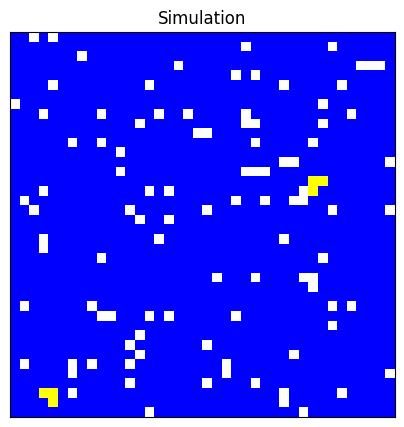

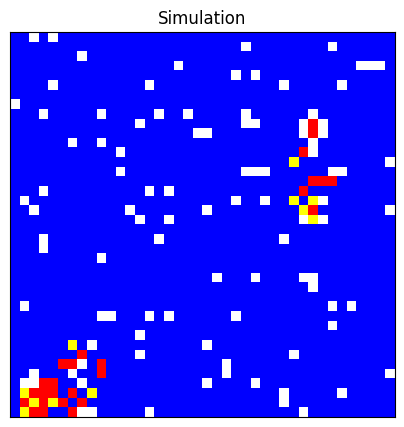

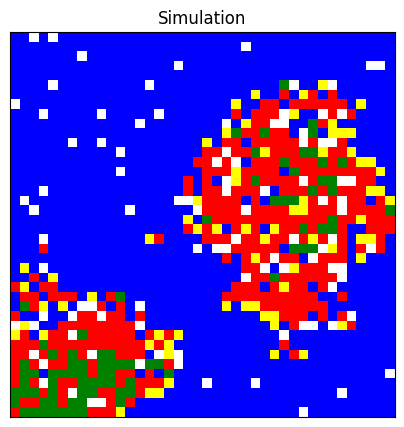

In [ ]:
grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=T_PROB, max_vis=6)
timesteps = [1, 5, 15]
for timestep in range(16):
  if timestep in timesteps:
    grid.draw()
  grid.step()

### More space to move + higher vision radius

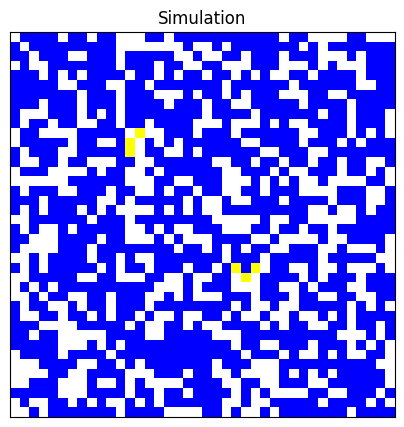

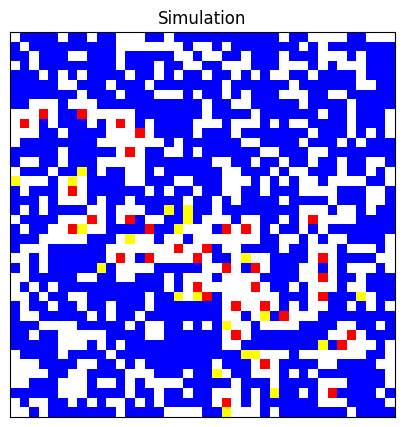

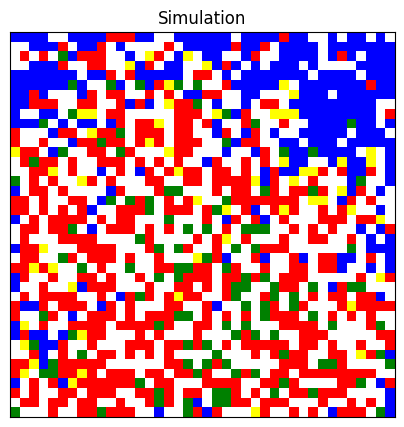

In [ ]:
grid = DAS(40, 40, num_agents=1000, num_infected=2, max_vis=10)
timesteps = [1, 5, 15]
for timestep in range(16):
  if timestep in timesteps:
    grid.draw()
  grid.step()

### Changing t_prob

Average loneliness over time with different transmission probabilities

0.6 0.4462222222222223
0.5 0.4391666666666668
0.4 0.47100000000000014
0.3 0.5020555555555557
0.2 0.5312777777777778


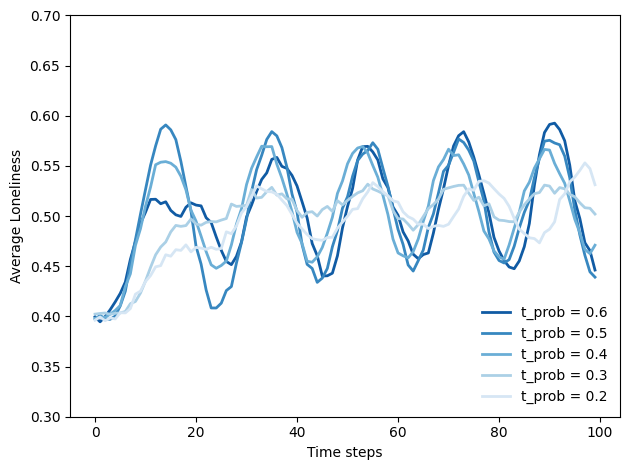

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for t_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='t_prob = %.1f' % t_prob)
  print(t_prob, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='lower right', ylim=[0.3, 0.7])

Number of sick agents over time with different transmission probabilities

0.6 221
0.5 250
0.4 397
0.3 507
0.2 636


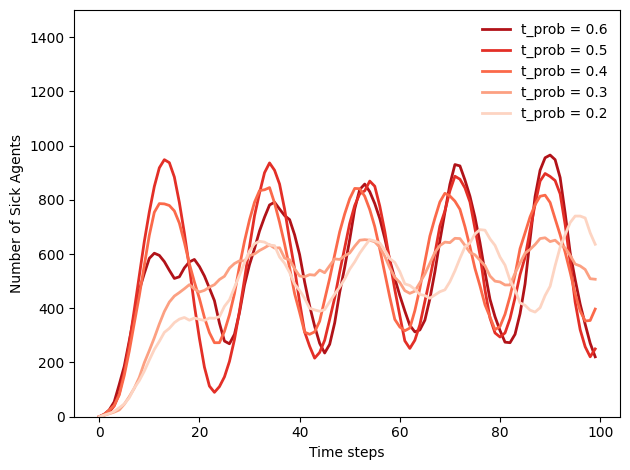

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for t_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='t_prob = %.1f' % t_prob)
  print(t_prob, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='upper right', ylim=[0, 1500])

Modelling average loneliness against the number of sick agents with varying transmission probabilities

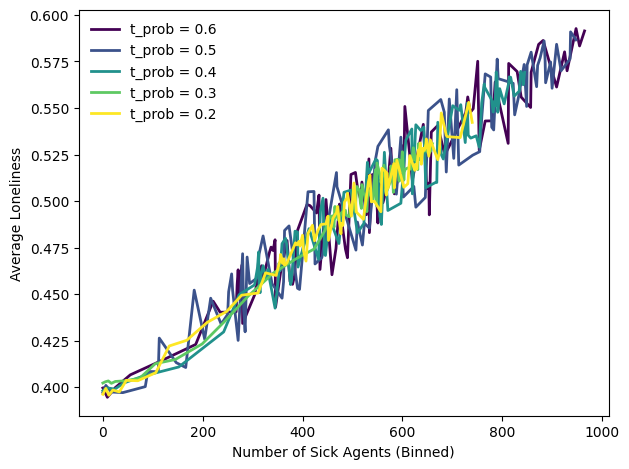

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Transmission probabilities to iterate over
t_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(t_probs)))  # Generate different colors for each t_prob

# Loop over each transmission probability
for color_idx, t_prob in enumerate(t_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f't_prob = {t_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='upper left')


In a log-log scale

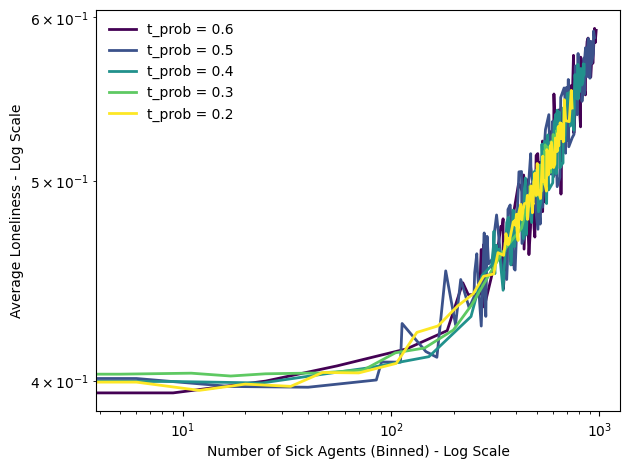

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Transmission probabilities to iterate over
t_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(t_probs)))  # Generate distinct colors for each t_prob

# Loop over each transmission probability
for color_idx, t_prob in enumerate(t_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f't_prob = {t_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper left')


### Changing i_prob

Average loneliness over time with different interaction probabilities

0.6 0.45061111111111124
0.5 0.5018333333333335
0.4 0.5508333333333335
0.3 0.5752222222222223
0.2 0.6162777777777778


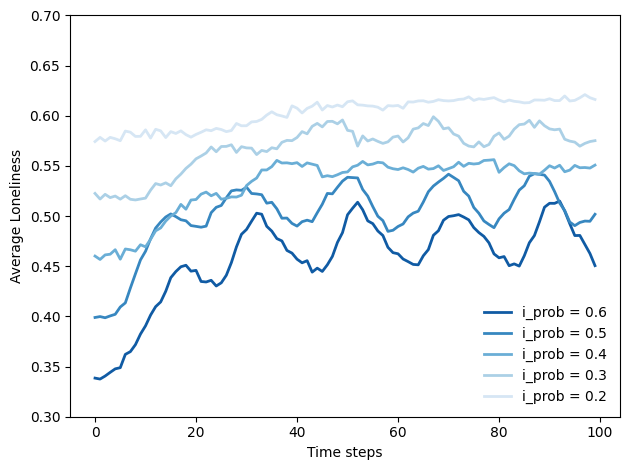

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for i_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='i_prob = %.1f' % i_prob)
  print(i_prob, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='lower right', ylim=[0.3, 0.7])

Number of sick agents over time with different interaction probabilities

0.6 481
0.5 554
0.4 562
0.3 528
0.2 488


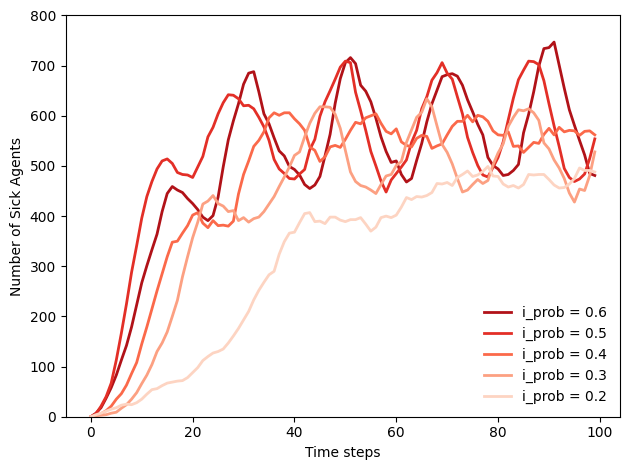

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for i_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='i_prob = %.1f' % i_prob)
  print(i_prob, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='lower right', ylim=[0, 800])

Modelling average loneliness against the number of sick agents with varying interaction probabilities

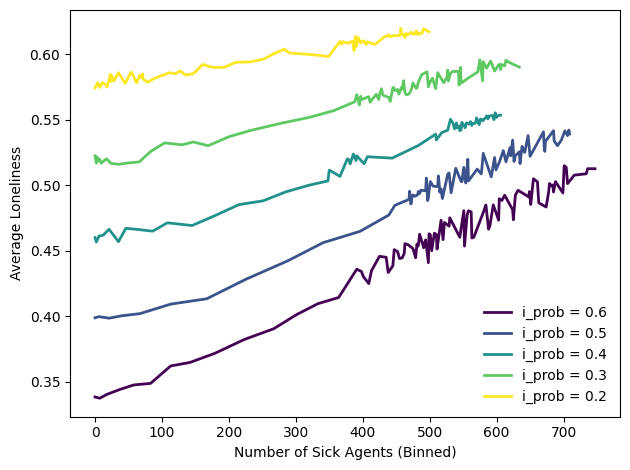

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Interaction probabilities to iterate over
i_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(i_probs)))  # Generate distinct colors for each i_prob

# Loop over each interaction probability
for color_idx, i_prob in enumerate(i_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'i_prob = {i_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='lower right')


In a log-log scale

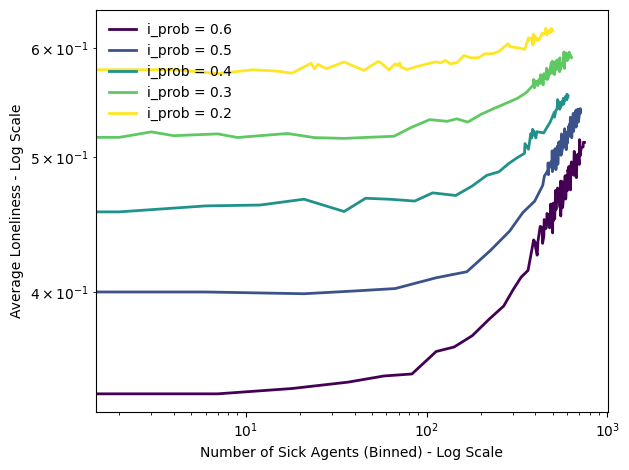

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Interaction probabilities to iterate over
i_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(i_probs)))  # Generate distinct colors for each i_prob

# Loop over each interaction probability
for color_idx, i_prob in enumerate(i_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'i_prob = {i_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper left')


### Changing population size

Average loneliness over time with different population size

1500 0.521888888888889
1400 0.530357142857143
1200 0.6063194444444445
1000 0.6600833333333335
500 0.8043333333333335


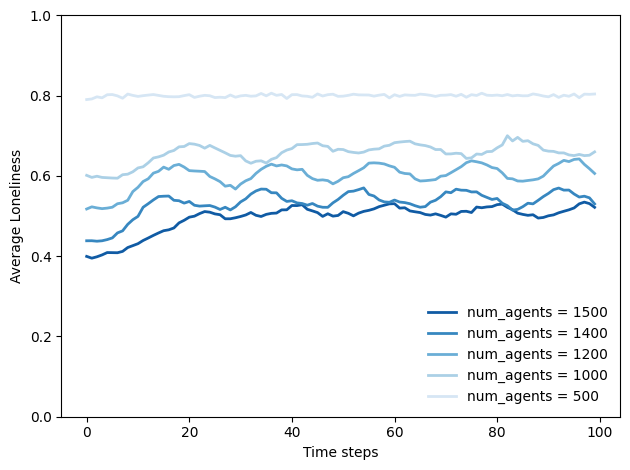

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for num_agents in [1500, 1400, 1200, 1000, 500]:
  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='num_agents = %i' % num_agents)
  print(num_agents, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='lower right', ylim=[0, 1])

Number of sick agents over time with different population sizes

1500 593
1400 456
1200 412
1000 350
500 0


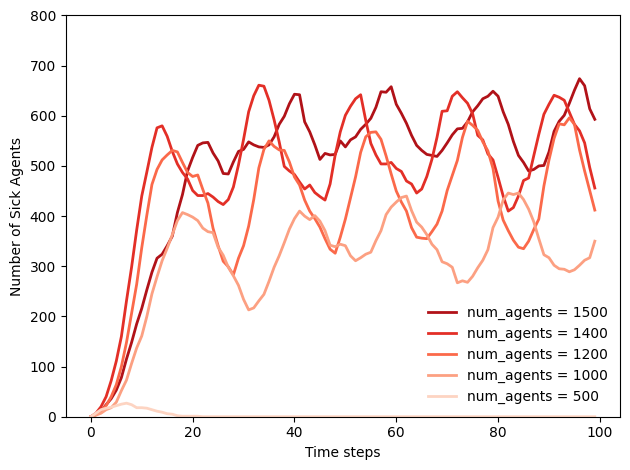

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for num_agents in [1500, 1400, 1200, 1000, 500]:
  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='num_agents = %i' % num_agents)
  print(num_agents, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='lower right', ylim=[0, 800])

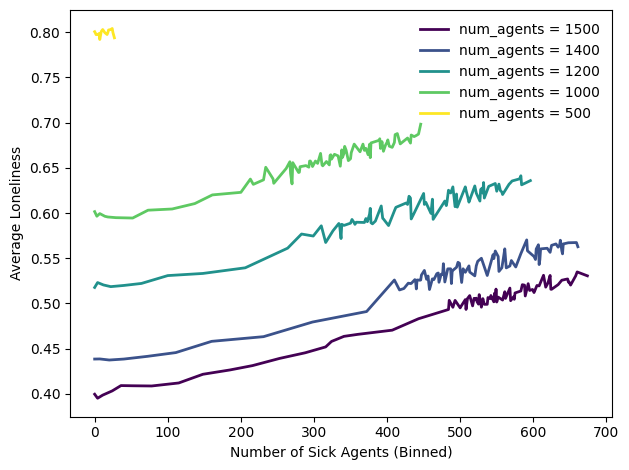

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Population sizes/densities to iterate over
pop_sizes =[1500, 1400, 1200, 1000, 500]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(pop_sizes)))  # Generate distinct colors for each population size/density

# Loop over each population size/density
for color_idx, num_agents in enumerate(pop_sizes):

  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'num_agents = {num_agents}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='upper right')


In a log-log scale

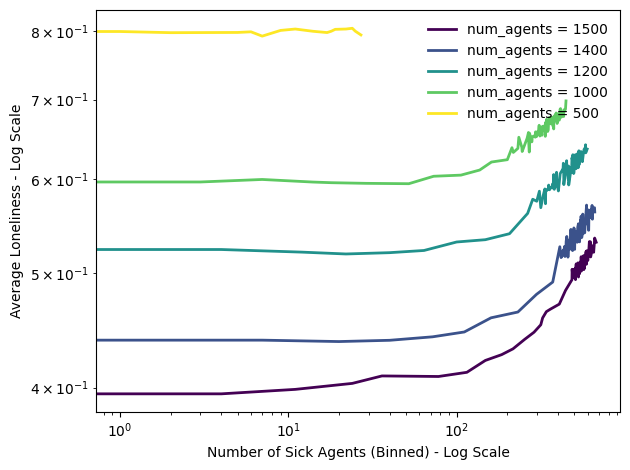

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Population sizes/densities to iterate over
pop_sizes =[1500, 1400, 1200, 1000, 500]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(pop_sizes)))  # Generate distinct colors for each population size/density

# Loop over each population size/density
for color_idx, num_agents in enumerate(pop_sizes):

  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'num_agents = {num_agents}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper right')


## Modelling COVID-19

Default transmission probability has been increased.

In [ ]:

# Periods
INCUBATION_PERIOD = 5
SICK_PERIOD = 7
IMMUNITY_PERIOD = 14

# Probabilities
T_PROB = 0.5 #Transmission probability (0-1)
# Increased default transmission probability
I_PROB = 0.5 #Interaction probability (0-1)

# grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=T_PROB, max_vis=6)
# grid.animate(frames=60, interval=0.1)

### Tight Space

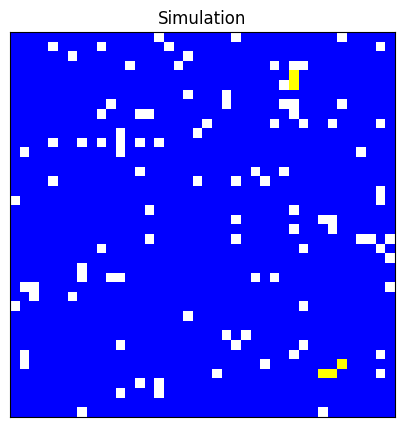

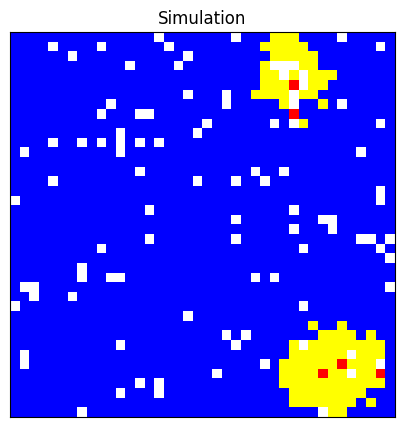

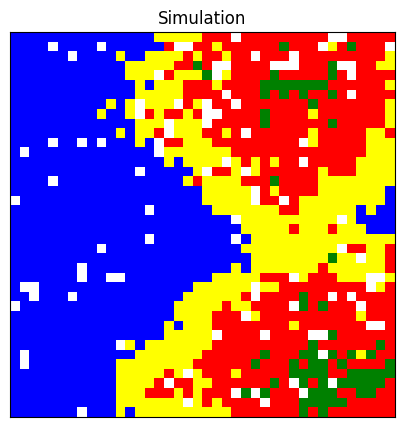

In [ ]:
grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=T_PROB, max_vis=6)
timesteps = [1, 5, 15]
for timestep in range(16):
  if timestep in timesteps:
    grid.draw()
  grid.step()

### More space to move + higher vision radius

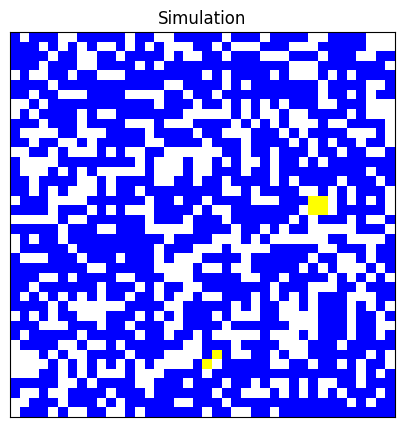

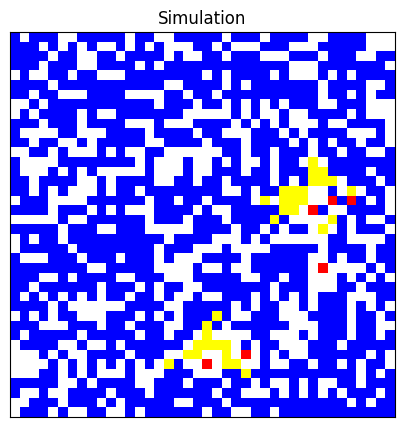

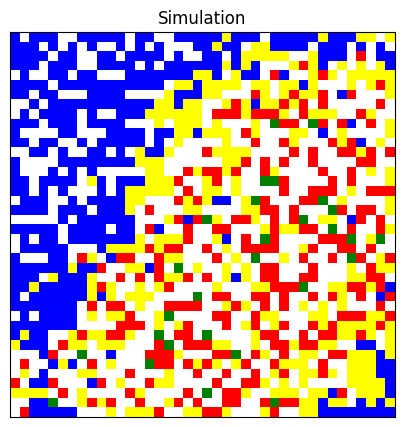

In [ ]:
grid = DAS(40, 40, num_agents=1000, num_infected=2, max_vis=10)
timesteps = [1, 5, 15]
for timestep in range(16):
  if timestep in timesteps:
    grid.draw()
  grid.step()

### Changing t_prob

Average loneliness over time with different transmission probabilities

0.6 0.4505000000000002
0.5 0.3929444444444445
0.4 0.4713333333333335
0.3 0.4652222222222223
0.2 0.46688888888888896


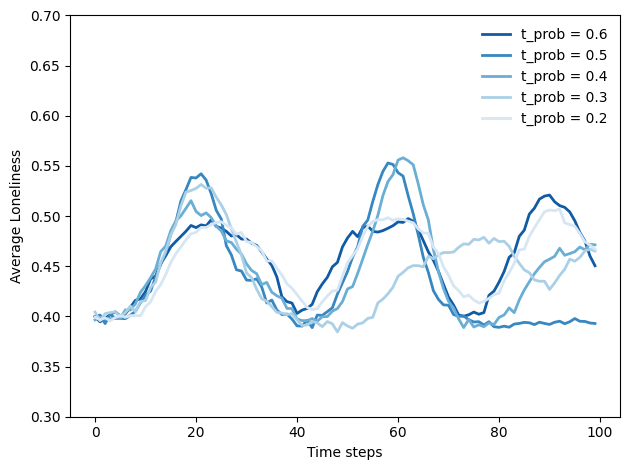

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for t_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='t_prob = %.1f' % t_prob)
  print(t_prob, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='upper right', ylim=[0.3, 0.7])

Number of sick agents over time with different transmission probabilities

0.6 233
0.5 0
0.4 410
0.3 352
0.2 341


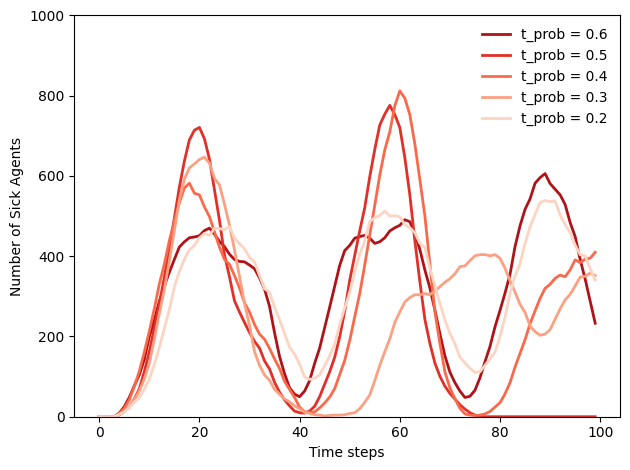

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for t_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='t_prob = %.1f' % t_prob)
  print(t_prob, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='upper right', ylim=[0, 1000])

Modelling average loneliness against the number of sick agents with varying transmission probabilities

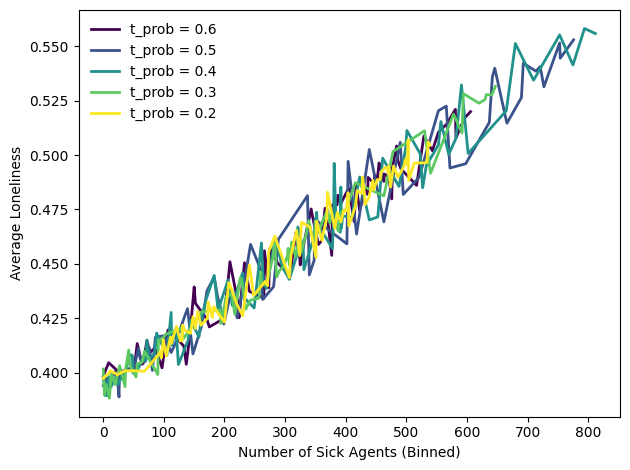

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Transmission probabilities to iterate over
t_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(t_probs)))  # Generate distinct colors for each t_prob

# Loop over each transmission probability
for color_idx, t_prob in enumerate(t_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f't_prob = {t_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='upper left')


In a log-log scale

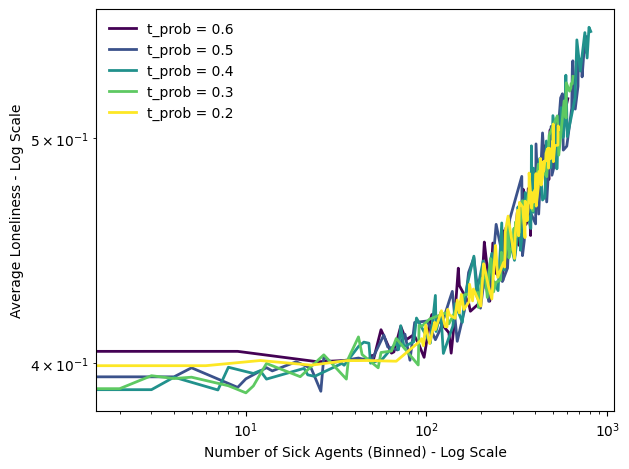

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Transmission probabilities to iterate over
t_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(t_probs)))  # Generate distinct colors for each t_prob

# Loop over each transmission probability
for color_idx, t_prob in enumerate(t_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, t_prob=t_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f't_prob = {t_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper left')


### Changing i_prob

Average loneliness over time with different interaction probabilities

0.6 0.3512777777777779
0.5 0.49005555555555563
0.4 0.511888888888889
0.3 0.5744444444444445
0.2 0.6092222222222223


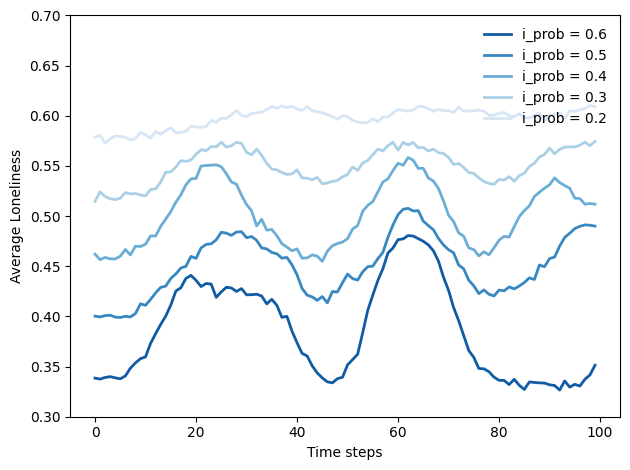

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for i_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='i_prob = %.1f' % i_prob)
  print(i_prob, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='upper right', ylim=[0.3, 0.7])

Number of sick agents over time with different interaction probabilities

0.6 114
0.5 439
0.4 338
0.3 468
0.2 381


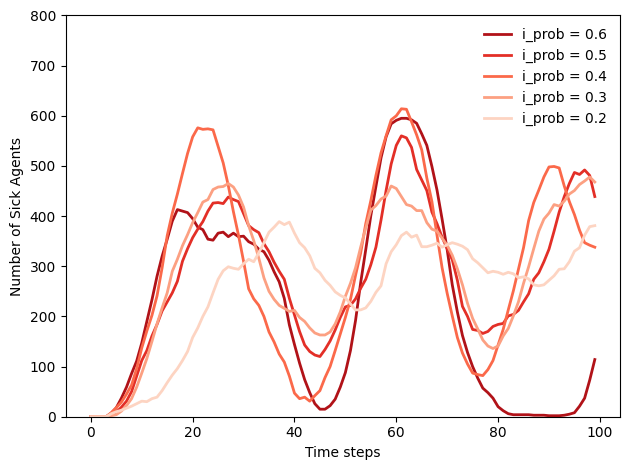

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for i_prob in [0.6, 0.5, 0.4, 0.3, 0.2]:
  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='i_prob = %.1f' % i_prob)
  print(i_prob, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='upper right', ylim=[0, 800])

Modelling average loneliness against the number of sick agents with varying interaction probabilities

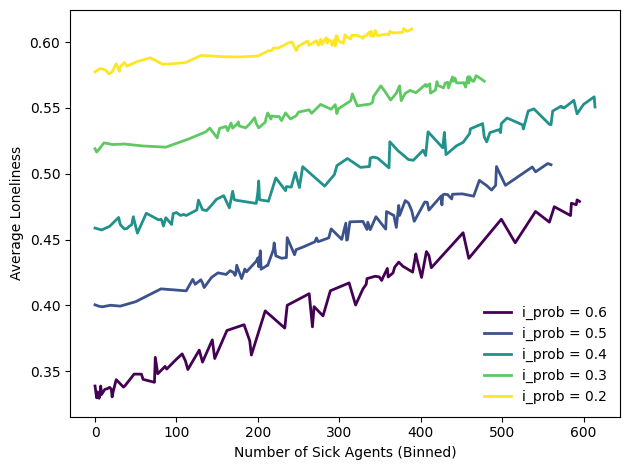

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Interaction probabilities to iterate over
i_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(i_probs)))  # Generate distinct colors for each i_prob

# Loop over each interaction probability
for color_idx, i_prob in enumerate(i_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'i_prob = {i_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='lower right')


In a log-log scale

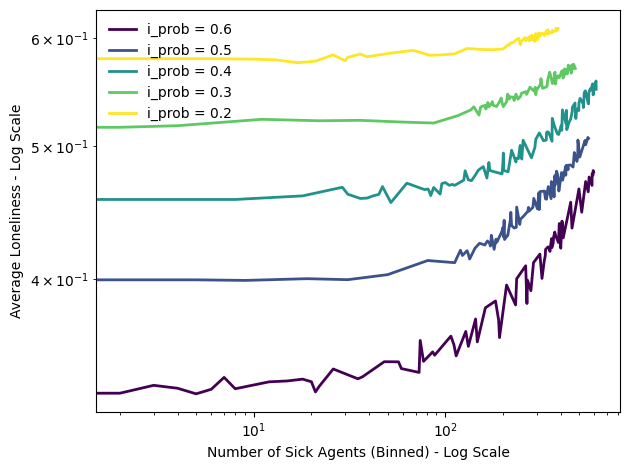

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Interaction probabilities to iterate over
i_probs = [0.6, 0.5, 0.4, 0.3, 0.2]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(i_probs)))  # Generate distinct colors for each i_prob

# Loop over each interaction probability
for color_idx, i_prob in enumerate(i_probs):

  grid = DAS(40, 40, num_agents=1500, num_infected=2, i_prob=i_prob, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'i_prob = {i_prob}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper left')


### Changing population size

Average loneliness over time with different population size

1500 0.4349444444444446
1400 0.5476785714285715
1200 0.609027777777778
1000 0.6435
500 0.837


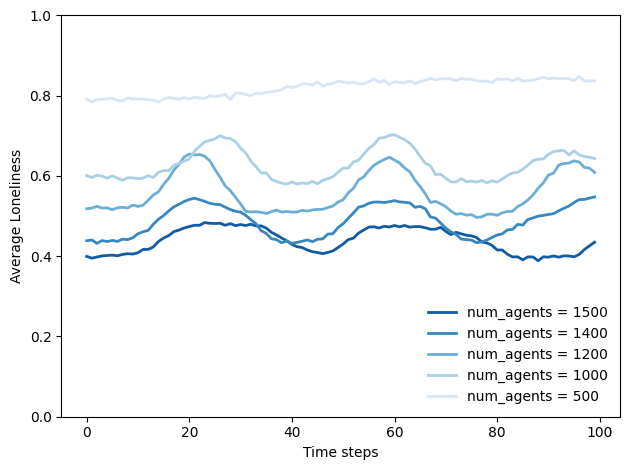

In [ ]:
set_palette('Blues', 5, reverse=True)

np.random.seed(19)
for num_agents in [1500, 1400, 1200, 1000, 500]:
  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)
  avg_loneliness = []
  for i in range(100):
    loneliness, _ = grid.step()
    avg_loneliness.append(loneliness)
  plt.plot(avg_loneliness, label='num_agents = %i' % num_agents)
  print(num_agents, avg_loneliness[-1])

decorate(xlabel='Time steps', ylabel='Average Loneliness',
         loc='lower right', ylim=[0, 1])

Number of sick agents over time with different population sizes

1500 278
1400 539
1200 410
1000 260
500 46


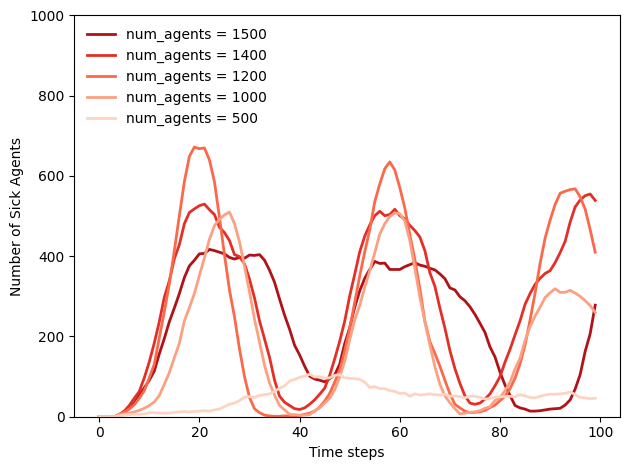

In [ ]:
set_palette('Reds', 5, reverse=True)

np.random.seed(19)
for num_agents in [1500, 1400, 1200, 1000, 500]:
  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)
  num_sick = []
  for i in range(100):
    _, sick = grid.step()
    num_sick.append(sick)
  plt.plot(num_sick, label='num_agents = %i' % num_agents)
  print(num_agents, num_sick[-1])

decorate(xlabel='Time steps', ylabel='Number of Sick Agents',
         loc='upper left', ylim=[0, 1000])

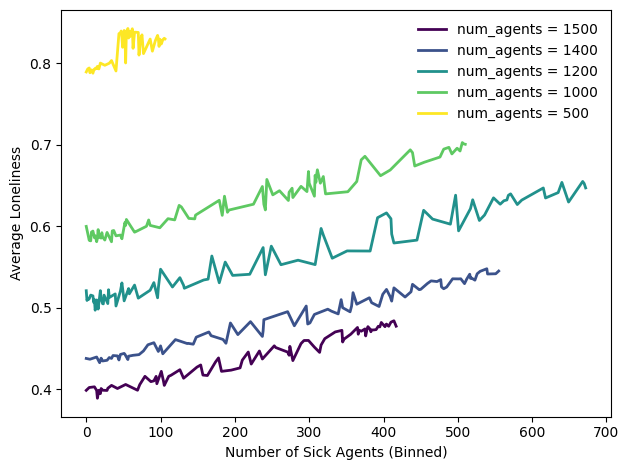

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Population sizes/densities to iterate over
pop_sizes =[1500, 1400, 1200, 1000, 500]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(pop_sizes)))  # Generate distinct colors for each population size/density

# Loop over each population size/density
for color_idx, num_agents in enumerate(pop_sizes):

  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'num_agents = {num_agents}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned)', ylabel='Average Loneliness',
         loc='upper right')


In a log-log scale

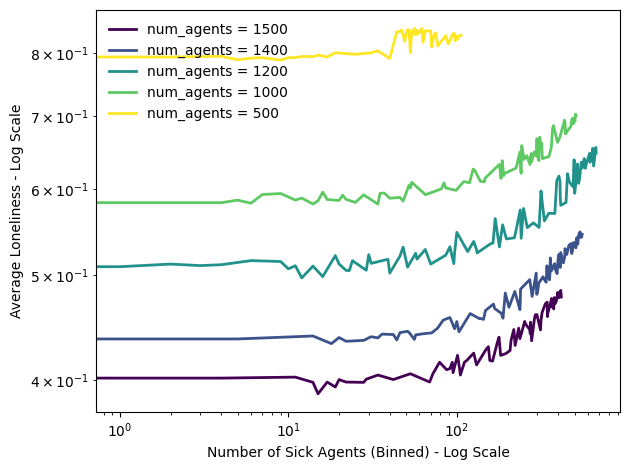

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

np.random.seed(19)

# Population sizes/densities to iterate over
pop_sizes =[1500, 1400, 1200, 1000, 500]

# Set the color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(pop_sizes)))  # Generate distinct colors for each population size/density

# Loop over each population size/density
for color_idx, num_agents in enumerate(pop_sizes):

  grid = DAS(40, 40, num_agents=num_agents, num_infected=2, max_vis=6)

  # Lists for tracking average loneliness and num sick at each timestep
  avg_loneliness = []
  num_sick = []

  # Track loneliness and sick count for each timestep
  for i in range(100):
    loneliness, sick = grid.step()
    avg_loneliness.append(loneliness)
    num_sick.append(sick)

  # Dictionary to store the values of loneliness corresponding to each num_sick bin
  loneliness_bins = defaultdict(list)

  # Bin the num_sick values and store their loneliness values
  for sickness, loneliness in zip(num_sick, avg_loneliness):
    bin_index = sickness
    loneliness_bins[bin_index].append(loneliness)

  # Calculate the average loneliness for each bin of num_sick
  binned_sick = sorted(loneliness_bins.keys())  # num_sick values in sorted order
  binned_avg_loneliness = [np.mean(loneliness_bins[bin_index]) for bin_index in binned_sick]

  plt.plot(binned_sick, binned_avg_loneliness, label=f'num_agents = {num_agents}', color=colors[color_idx])


decorate(xlabel='Number of Sick Agents (Binned) - Log Scale',xscale='log', ylabel='Average Loneliness - Log Scale', yscale='log',
         loc='upper left')
